In [25]:
import pandas as pd
import os

from tqdm import tqdm

archive_dir = "../archive"

merged_df = pd.DataFrame()

for file in tqdm(os.listdir(archive_dir)):
    file_path = f"{archive_dir}/{file}"
    ticker = file.replace(".csv", "")

    df = pd.read_csv(file_path)
    df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.date
    df = df.groupby("timestamp").last()
    df = df.rename(columns={"users_holding": ticker})

    if merged_df.empty:
        merged_df = df
    else:
        merged_df = merged_df.join(df, how="outer")

# Optional: sort index (date) and columns
merged_df = merged_df.sort_index().sort_index(axis=1)


    

100%|██████████| 8619/8619 [09:05<00:00, 15.79it/s]


In [27]:
merged_df.to_parquet("../data/df_rh_last.parquet")

now get the list of inadmissible values

In [29]:
df = pd.read_parquet("../data/df_rh_last.parquet")
df

A      AA    AAAU  AACAY  AACG  AADR  AAGIY     AAL  AAMC  \
timestamp                                                                  
2018-05-02   590     NaN     NaN    NaN    55   NaN    NaN    3755   NaN   
2018-05-03   587     NaN     NaN    NaN    55   NaN    NaN    3775   NaN   
2018-05-04   588     NaN     NaN    NaN    56   NaN    NaN    3748   NaN   
2018-05-05   588     NaN     NaN    NaN    56   NaN    NaN    3748   NaN   
2018-05-06   588     NaN     NaN    NaN    56   NaN    NaN    3748   NaN   
...          ...     ...     ...    ...   ...   ...    ...     ...   ...   
2020-08-09  1616  5678.0  1727.0  361.0  1664  13.0  334.0  641785  89.0   
2020-08-10  1625  5667.0  1746.0  358.0  1650  13.0  334.0  639029  87.0   
2020-08-11  1624  5718.0  1704.0  360.0  1643  13.0  336.0  640944  87.0   
2020-08-12  1628  5694.0  1701.0  357.0  1646  13.0  335.0  639107  88.0   
2020-08-13  1642  5699.0  1712.0  356.0  1644  12.0  331.0  637705  89.0   

            AAME  ...   ZTS  ZUMZ   ZUO  ZURVY     ZVO   ZYME   ZYNE    ZYXI  \
timestamp         ...                                                          
2018-05-02   119  ...   588   248   539    NaN     NaN    NaN   6127     NaN   
2018-05-03   119  ...   609   251   546    NaN     NaN    NaN   6150     NaN   
2018-05-04   119  ...   607   247   550    NaN     NaN    NaN   6140     NaN   
2018-05-05   119  ...   607   247   550    NaN     NaN    NaN   6140     NaN   
2018-05-06   119  ...   607   247   550    NaN     NaN    NaN   6140     NaN   
...          ...  ...   ...   ...   ...    ...     ...    ...    ...     ...   
2020-08-09   260  ...  2735   494  6202  231.0  5806.0  674.0  32097  3192.0   
2020-08-10   258  ...  2735   504  6301  228.0  5679.0  675.0  31977  3178.0   
2020-08-11   254  ...  2725   500  6320  229.0  5541.0  674.0  31860  3150.0   
2020-08-12   253  ...  2747   495  6312  231.0  5391.0  672.0  31821  3147.0   
2020-08-13   250  ...  2739   496  6298  233.0  5332.0  666.0  31720  3114.0   

            _OUT  _PRN  
timestamp               
2018-05-02   158  12.0  
2018-05-03   154  12.0  
2018-05-04   154  12.0  
2018-05-05   154  12.0  
2018-05-06   154  12.0  
...          ...   ...  
2020-08-09  2021  23.0  
2020-08-10  2007  24.0  
2020-08-11  1994  24.0  
2020-08-12  1990  24.0  
2020-08-13  1988  25.0  

[818 rows x 8619 columns]

In [32]:
import pandas as pd
import numpy as np

def has_internal_nans(series):
    """Check if a time series has NaNs not at the beginning or end."""
    notna = series.notna()
    # Only consider if there’s at least one non-NaN (otherwise meaningless)
    if not notna.any():
        return False
    # Find first and last valid index
    first_valid = notna.idxmax()
    last_valid = notna[::-1].idxmax()
    # Slice between the first and last valid index
    internal = series.loc[first_valid:last_valid]
    return internal.isna().any()

# Assuming your DataFrame is dl.df_rh with a MultiIndex (date, ticker)
# and a column called 'num_investors' (or similar)


# Identify tickers with internal (non-edge) NaNs
tickers_with_holes = [col for col in df if has_internal_nans(df[col])]

print(f"{len(tickers_with_holes)} tickers have internal NaNs (non-leading/trailing).")


402 tickers have internal NaNs (non-leading/trailing).


In [3]:
fedyk_tickers = [
    "AKO.A", "AKO.B", "BF.A", "BF.B", "BH", "BH.A",
    "BIO", "BIO.B", "BRK.A", "BRK.B", "BWL.A", "CIG",
    "CIG.C", "CRD.A", "CRD.B", "CWEN", "CWEN.A", "EBR",
    "EBR.B", "GEF", "GEF.B", "GTN", "GTN.A", "HEI",
    "HEI.A", "HVT", "HVT.A", "JW.A", "JW.B", "LEN",
    "LEN.B", "LGF.A", "LGF.B", "MKC", "MKC.V", "MOG.A",
    "MOG.B", "OIBR.C", "PBR", "PBR.A", "RDS.A", "RDS.B",
    "STZ", "STZ.B", "TAP", "TAP.A", "WSO", "WSO.B"
]

len(fedyk_tickers)

48

In [1]:
8619-48

8571

In [39]:
excluded_tickers = fedyk_tickers 
excluded_tickers = set(excluded_tickers)
excluded_tickers = sorted(list(excluded_tickers))
excluded_tickers = {"excluded_tickers":excluded_tickers}
excluded_tickers

{'excluded_tickers': ['AKO.A',
  'AKO.B',
  'BF.A',
  'BF.B',
  'BH',
  'BH.A',
  'BIO',
  'BIO.B',
  'BRK.A',
  'BRK.B',
  'BWL.A',
  'CIG',
  'CIG.C',
  'CRD.A',
  'CRD.B',
  'CWEN',
  'CWEN.A',
  'EBR',
  'EBR.B',
  'GEF',
  'GEF.B',
  'GTN',
  'GTN.A',
  'HEI',
  'HEI.A',
  'HVT',
  'HVT.A',
  'JW.A',
  'JW.B',
  'LEN',
  'LEN.B',
  'LGF.A',
  'LGF.B',
  'MKC',
  'MKC.V',
  'MOG.A',
  'MOG.B',
  'OIBR.C',
  'PBR',
  'PBR.A',
  'RDS.A',
  'RDS.B',
  'STZ',
  'STZ.B',
  'TAP',
  'TAP.A',
  'WSO',
  'WSO.B']}

In [41]:
import json

with open("../data/tickers/tickers_to_exclude.json", "w") as f:
    json.dump(excluded_tickers, f, indent=4)



In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from src import DataLoader

dl = DataLoader(handle_nans="zero", load_merged=True, load_other_dfs=True)

#df_compare = dl.merge_dfs()


2025-04-20 20:54:59,148 - src.data_loader - DEBUG - self.df_robinhood_path: D:\Uni\Bocconi\Thesis\Robinhood_data\data\df_rh_last.parquet (data_loader.py:60)
2025-04-20 20:54:59,148 - src.data_loader - DEBUG - self.df_wrds_path: D:\Uni\Bocconi\Thesis\Robinhood_data\data\df_wrds.parquet (data_loader.py:61)
2025-04-20 20:54:59,148 - src.data_loader - DEBUG - self.df_crsp_path: D:\Uni\Bocconi\Thesis\Robinhood_data\data\df_crsp_div.parquet (data_loader.py:62)
2025-04-20 20:54:59,148 - src.data_loader - DEBUG - self.df_merged_path: D:\Uni\Bocconi\Thesis\Robinhood_data\data\df_merged_zero.parquet (data_loader.py:63)
2025-04-20 20:55:00,965 - src.data_loader - DEBUG - len cols to keep: 8571 (data_loader.py:87)
2025-04-20 20:55:01,247 - src.data_loader - INFO - Robinhood data loaded (data_loader.py:121)
2025-04-20 20:55:03,030 - src.data_loader - INFO - CRSP data loaded (data_loader.py:141)


In [5]:
df_crsp = dl.df_crsp
df_crsp[df_crsp["ticker"].isin(fedyk_tickers)]["shrcd"].unique()

array([11., 31.])

In [118]:
df_crsp[df_crsp["ticker"]=="HNDL"]

permno       date  shrcd ticker   divamt      prc      vol       ret  \
1520852   17264 2018-05-02   73.0   HNDL  0.00000  23.8750     18.0 -0.002715   
1520853   17264 2018-05-03   73.0   HNDL  0.00000  23.8392   5310.0 -0.001500   
1520854   17264 2018-05-04   73.0   HNDL  0.00000  23.8626   9216.0  0.000982   
1520855   17264 2018-05-07   73.0   HNDL  0.00000  23.9866   5001.0  0.005196   
1520856   17264 2018-05-08   73.0   HNDL  0.00000  24.7100   1600.0  0.030158   
...         ...        ...    ...    ...      ...      ...      ...       ...   
1521436   17264 2020-08-10   73.0   HNDL  0.00000  25.1175  68217.0  0.001084   
1521437   17264 2020-08-11   73.0   HNDL  0.00000  25.0000  37711.0 -0.004678   
1521438   17264 2020-08-12   73.0   HNDL  0.00000  25.0200  53059.0  0.000800   
1521439   17264 2020-08-13   73.0   HNDL  0.11050  24.9215  24982.0  0.001864   
1521440   17264 2020-08-13   73.0   HNDL  0.03463  24.9215  24982.0  0.001864   

         shrout  cfacshr_adj  cfacpr_adj  prc_adj  shrout_adj  
1520852   150.0          1.0         1.0  23.8750    150000.0  
1520853   150.0          1.0         1.0  23.8392    150000.0  
1520854   150.0          1.0         1.0  23.8626    150000.0  
1520855   150.0          1.0         1.0  23.9866    150000.0  
1520856   150.0          1.0         1.0  24.7100    150000.0  
...         ...          ...         ...      ...         ...  
1521436  1800.0          1.0         1.0  25.1175   1800000.0  
1521437  1800.0          1.0         1.0  25.0000   1800000.0  
1521438  1850.0          1.0         1.0  25.0200   1850000.0  
1521439  1850.0          1.0         1.0  24.9215   1850000.0  
1521440  1850.0          1.0         1.0  24.9215   1850000.0  

[589 rows x 13 columns]

In [108]:
df_crsp["ticker"].nunique()

8345

In [119]:
# Ensure the date column is datetime
df_crsp["date"] = pd.to_datetime(df_crsp["date"])

# Group by date (and optionally ticker if you have multiple securities), then sum dividends
daily_divs = df_crsp.groupby(["date", "ticker"])["divamt"].sum().reset_index()
daily_divs

date ticker  divamt
0       2018-05-02      A     0.0
1       2018-05-02     AA     0.0
2       2018-05-02   AADR     0.0
3       2018-05-02    AAL     0.0
4       2018-05-02   AAMC     0.0
...            ...    ...     ...
4163996 2020-08-13    ZUO     0.0
4163997 2020-08-13    ZVO     0.0
4163998 2020-08-13   ZYME     0.0
4163999 2020-08-13   ZYNE     0.0
4164000 2020-08-13   ZYXI     0.0

[4164001 rows x 3 columns]

In [120]:
df_crsp = df_crsp.drop(columns=["divamt"])

# 2. Merge the new, aggregated dividend data
df_crsp = df_crsp.merge(daily_divs, on=["date", "ticker"], how="left")


df_crsp = df_crsp.drop_duplicates()

In [121]:
df_crsp[df_crsp["ticker"]=="HNDL"]

permno       date  shrcd ticker      prc      vol       ret  shrout  \
1519013   17264 2018-05-02   73.0   HNDL  23.8750     18.0 -0.002715   150.0   
1519014   17264 2018-05-03   73.0   HNDL  23.8392   5310.0 -0.001500   150.0   
1519015   17264 2018-05-04   73.0   HNDL  23.8626   9216.0  0.000982   150.0   
1519016   17264 2018-05-07   73.0   HNDL  23.9866   5001.0  0.005196   150.0   
1519017   17264 2018-05-08   73.0   HNDL  24.7100   1600.0  0.030158   150.0   
...         ...        ...    ...    ...      ...      ...       ...     ...   
1519596   17264 2020-08-07   73.0   HNDL  25.0903  45327.0  0.000088  1700.0   
1519597   17264 2020-08-10   73.0   HNDL  25.1175  68217.0  0.001084  1800.0   
1519598   17264 2020-08-11   73.0   HNDL  25.0000  37711.0 -0.004678  1800.0   
1519599   17264 2020-08-12   73.0   HNDL  25.0200  53059.0  0.000800  1850.0   
1519600   17264 2020-08-13   73.0   HNDL  24.9215  24982.0  0.001864  1850.0   

         cfacshr_adj  cfacpr_adj  prc_adj  shrout_adj   divamt  
1519013          1.0         1.0  23.8750    150000.0  0.00000  
1519014          1.0         1.0  23.8392    150000.0  0.00000  
1519015          1.0         1.0  23.8626    150000.0  0.00000  
1519016          1.0         1.0  23.9866    150000.0  0.00000  
1519017          1.0         1.0  24.7100    150000.0  0.00000  
...              ...         ...      ...         ...      ...  
1519596          1.0         1.0  25.0903   1700000.0  0.00000  
1519597          1.0         1.0  25.1175   1800000.0  0.00000  
1519598          1.0         1.0  25.0000   1800000.0  0.00000  
1519599          1.0         1.0  25.0200   1850000.0  0.00000  
1519600          1.0         1.0  24.9215   1850000.0  0.14513  

[576 rows x 13 columns]

In [123]:
excluded_tickers = fedyk_tickers
excluded_tickers = set(excluded_tickers)
excluded_tickers = sorted(list(excluded_tickers))
excluded_tickers = {"excluded_tickers":excluded_tickers}
excluded_tickers

{'excluded_tickers': ['AKO.A',
  'AKO.B',
  'BF.A',
  'BF.B',
  'BH',
  'BH.A',
  'BIO',
  'BIO.B',
  'BRK.A',
  'BRK.B',
  'BWL.A',
  'CIG',
  'CIG.C',
  'CRD.A',
  'CRD.B',
  'CWEN',
  'CWEN.A',
  'EBR',
  'EBR.B',
  'GEF',
  'GEF.B',
  'GTN',
  'GTN.A',
  'HEI',
  'HEI.A',
  'HVT',
  'HVT.A',
  'JW.A',
  'JW.B',
  'LEN',
  'LEN.B',
  'LGF.A',
  'LGF.B',
  'MKC',
  'MKC.V',
  'MOG.A',
  'MOG.B',
  'OIBR.C',
  'PBR',
  'PBR.A',
  'RDS.A',
  'RDS.B',
  'STZ',
  'STZ.B',
  'TAP',
  'TAP.A',
  'WSO',
  'WSO.B']}

In [124]:
import json

with open("../data/tickers/tickers_to_exclude.json", "w") as f:
    json.dump(excluded_tickers, f, indent=4)



In [2]:
import pandas as pd


df = pd.read_parquet("../data/df_rh_last.parquet")

df.shape

(818, 8619)

In [1]:
from src import DataLoader

dl = DataLoader(load_other_dfs=True)

dl.df_crsp

2025-04-21 21:17:59,156 - src.data_loader - INFO - Robinhood data loaded (data_loader.py:121)
2025-04-21 21:18:01,647 - src.data_loader - INFO - CRSP data loaded (data_loader.py:141)


permno       date  shrcd  ... cfacpr_adj     prc_adj   shrout_adj
0         10026 2018-05-02   11.0  ...        1.0   129.66000   18702000.0
1         10026 2018-05-03   11.0  ...        1.0   128.82001   18702000.0
2         10026 2018-05-04   11.0  ...        1.0   132.70000   18702000.0
3         10026 2018-05-07   11.0  ...        1.0   135.05000   18702000.0
4         10026 2018-05-08   11.0  ...        1.0   135.50000   18702000.0
...         ...        ...    ...  ...        ...         ...          ...
4182885   93436 2020-08-07   11.0  ...        1.0  1452.70996  186362000.0
4182886   93436 2020-08-10   11.0  ...        1.0  1418.56995  186362000.0
4182887   93436 2020-08-11   11.0  ...        1.0  1374.39001  186362000.0
4182888   93436 2020-08-12   11.0  ...        1.0  1554.76001  186362000.0
4182889   93436 2020-08-13   11.0  ...        1.0  1621.00000  186362000.0

[4170652 rows x 13 columns]

In [8]:
count = dl.df_crsp.groupby(["ticker", "date"]).size()
count[count>1]

ticker  date      
ACWI    2019-12-16    2
ACWX    2019-12-16    2
ADT     2019-12-12    2
ADX     2018-11-23    2
        2019-02-14    2
                     ..
YIN     2020-03-30    2
YLDE    2018-06-26    2
        2018-12-26    2
        2019-06-25    2
YOLO    2019-12-27    2
Length: 8563, dtype: int64

In [9]:
dl.df_crsp[dl.df_crsp["ticker"]=="ACWI"]

permno       date  shrcd  ... cfacpr_adj  prc_adj   shrout_adj
3966953   92585 2018-05-02   73.0  ...        1.0    71.61  116800000.0
3966954   92585 2018-05-03   73.0  ...        1.0    71.62  116800000.0
3966955   92585 2018-05-04   73.0  ...        1.0    72.22  116800000.0
3966956   92585 2018-05-07   73.0  ...        1.0    72.34  116800000.0
3966957   92585 2018-05-08   73.0  ...        1.0    72.37  116800000.0
...         ...        ...    ...  ...        ...      ...          ...
3967525   92585 2020-08-07   73.0  ...        1.0    79.36  154800000.0
3967526   92585 2020-08-10   73.0  ...        1.0    79.56  154800000.0
3967527   92585 2020-08-11   73.0  ...        1.0    79.28  154800000.0
3967528   92585 2020-08-12   73.0  ...        1.0    80.53  154800000.0
3967529   92585 2020-08-13   73.0  ...        1.0    80.36  154800000.0

[577 rows x 13 columns]

## check differencce in approaches

In [19]:
%load_ext autoreload 
%autoreload 2

In [12]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams
import numpy as np

return_params = ReturnParams(
    horizons={1},  
    cumulative=True,
    append_start=False
)

an_fedyk = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})
an_div = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", include_dividends=True, dl_kwargs={"weights_method":"dollar"})

r_fedyk, h_fedyk = an_fedyk.build_returns()
r_fedyk = np.exp(r_fedyk)-1

r_div, h_div = an_div.build_returns()
r_div = np.exp(r_div)-1



2025-05-14 09:21:55,334 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)
2025-05-14 09:21:59,434 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)
2025-05-14 09:22:01,688 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:204)
2025-05-14 09:22:01,947 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:204)


In [13]:
r_div

rh_portfolio  rh_portfolio_div  rh_portfolio_1_return  \
date                                                                
2018-05-03     -0.006027          0.000000              -0.006027   
2018-05-04      0.016832          0.000000               0.016832   
2018-05-07      0.008523         -0.327607               0.008523   
2018-05-08      0.004133         -0.278205               0.004133   
2018-05-09      0.010288          1.193228               0.010288   
...                  ...               ...                    ...   
2020-08-07     -0.003859          0.008537              -0.003859   
2020-08-10      0.019014          0.015430               0.019014   
2020-08-11     -0.019922         -0.025532              -0.019922   
2020-08-12      0.006672          0.020579               0.006672   
2020-08-13      0.004269          0.003015               0.004269   

            rh_portfolio_div_1_return  rh_portfolio_563_return  \
date                                                             
2018-05-03                   0.000000                -0.006027   
2018-05-04                   0.000000                 0.010703   
2018-05-07                  -0.327607                 0.019317   
2018-05-08                  -0.278205                 0.023530   
2018-05-09                   1.193228                 0.034061   
...                               ...                      ...   
2020-08-07                   0.008537                 0.353875   
2020-08-10                   0.015430                 0.379618   
2020-08-11                  -0.025532                 0.352133   
2020-08-12                   0.020579                 0.361154   
2020-08-13                   0.003015                 0.366966   

            rh_portfolio_div_563_return  
date                                     
2018-05-03                     0.000000  
2018-05-04                     0.000000  
2018-05-07                    -0.327607  
2018-05-08                    -0.514670  
2018-05-09                     0.064439  
...                                 ...  
2020-08-07                    66.609474  
2020-08-10                    67.652684  
2020-08-11                    65.899866  
2020-08-12                    67.276585  
2020-08-13                    67.482406  

[563 rows x 6 columns]

In [2]:

rt_w = RiskTests(an_fedyk, portfolio_column="pfioret100")
rt_w.factors

2025-05-14 09:20:01,591 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:204)


pfioret100    xmkt     smb     hml     rmw     cma       rf  \
2018-06-04    0.008014  0.0048  0.0015 -0.0046  0.0106 -0.0030  0.00006   
2018-06-05    0.008389  0.0016  0.0079 -0.0043  0.0023  0.0011  0.00006   
2018-06-06    0.009090  0.0086 -0.0028  0.0019 -0.0002  0.0015  0.00006   
2018-06-07   -0.004404 -0.0014 -0.0024  0.0091  0.0017  0.0059  0.00006   
2018-06-08    0.003415  0.0031  0.0005 -0.0041  0.0027 -0.0019  0.00006   
...                ...     ...     ...     ...     ...     ...      ...   
2020-08-07   -0.003010  0.0002  0.0152  0.0234  0.0049  0.0017  0.00000   
2020-08-10    0.018285  0.0024  0.0127  0.0166  0.0086  0.0124  0.00000   
2020-08-11   -0.021548 -0.0083  0.0018  0.0157  0.0089  0.0007  0.00000   
2020-08-12    0.009481  0.0140 -0.0081 -0.0130  0.0095 -0.0014  0.00000   
2020-08-13    0.003826 -0.0001 -0.0012 -0.0130 -0.0063 -0.0055  0.00000   

               umd      mkt  
2018-06-04  0.0017  0.00486  
2018-06-05  0.0029  0.00166  
2018-06-06 -0.0001  0.00866  
2018-06-07 -0.0091 -0.00134  
2018-06-08 -0.0013  0.00316  
...            ...      ...  
2020-08-07 -0.0201  0.00020  
2020-08-10 -0.0282  0.00240  
2020-08-11 -0.0221 -0.00830  
2020-08-12  0.0187  0.01400  
2020-08-13  0.0155 -0.00010  

[539 rows x 9 columns]

In [16]:
df_plot = rt_w.factors.merge(r_fedyk["rh_portfolio"], left_index=True, right_index=True, how="inner")
df_plot = df_plot[["pfioret100", "rh_portfolio"]]
df_plot = (df_plot+1).cumprod()-1
df_plot.columns = [f"{col}_1_return" for col in df_plot.columns]
df_plot

pfioret100_1_return  rh_portfolio_1_return
2018-06-04             0.008014               0.007979
2018-06-05             0.016470               0.015707
2018-06-06             0.025710               0.025424
2018-06-07             0.021193               0.020749
2018-06-08             0.024681               0.024296
...                         ...                    ...
2020-08-07             0.553890               0.231155
2020-08-10             0.582302               0.254564
2020-08-11             0.548206               0.229571
2020-08-12             0.562885               0.237775
2020-08-13             0.568864               0.243059

[539 rows x 2 columns]

In [17]:
r_div = r_div[[col for col in r_div.columns if "div_563" in col]]
r_div

rh_portfolio_div_563_return
date                                   
2018-05-03                     0.000000
2018-05-04                     0.000000
2018-05-07                    -0.327607
2018-05-08                    -0.514670
2018-05-09                     0.064439
...                                 ...
2020-08-07                    66.609474
2020-08-10                    67.652684
2020-08-11                    65.899866
2020-08-12                    67.276585
2020-08-13                    67.482406

[563 rows x 1 columns]

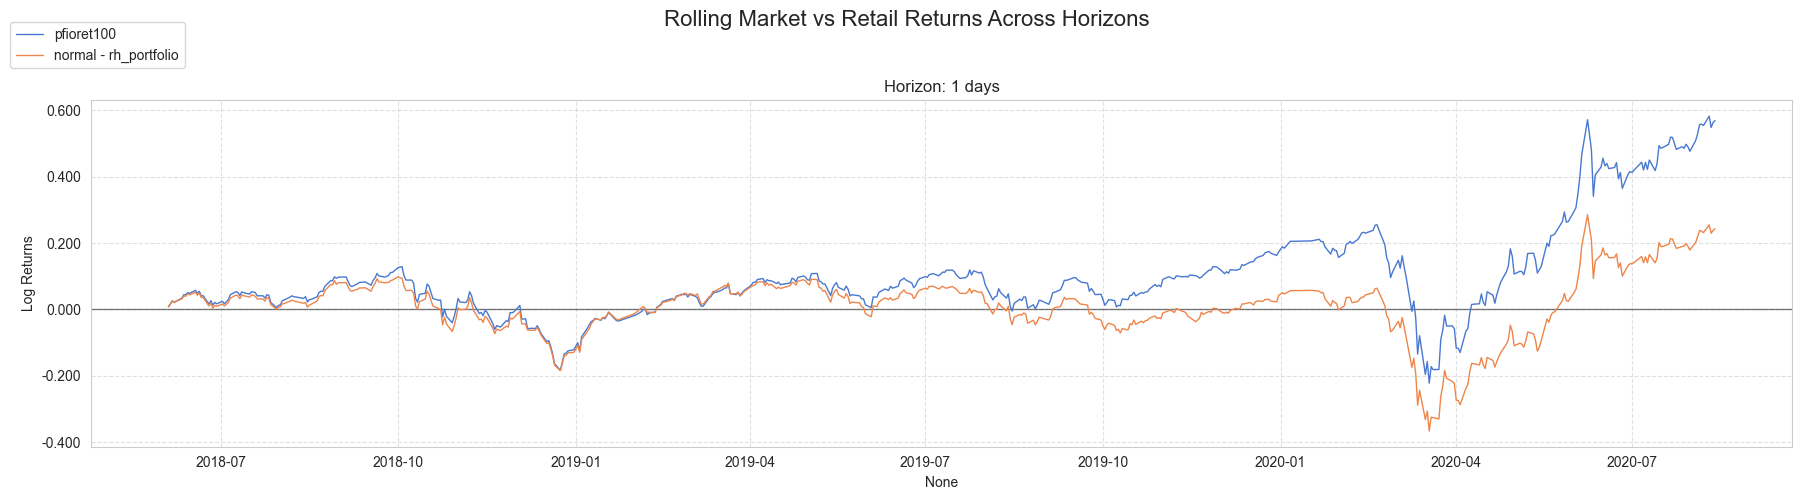

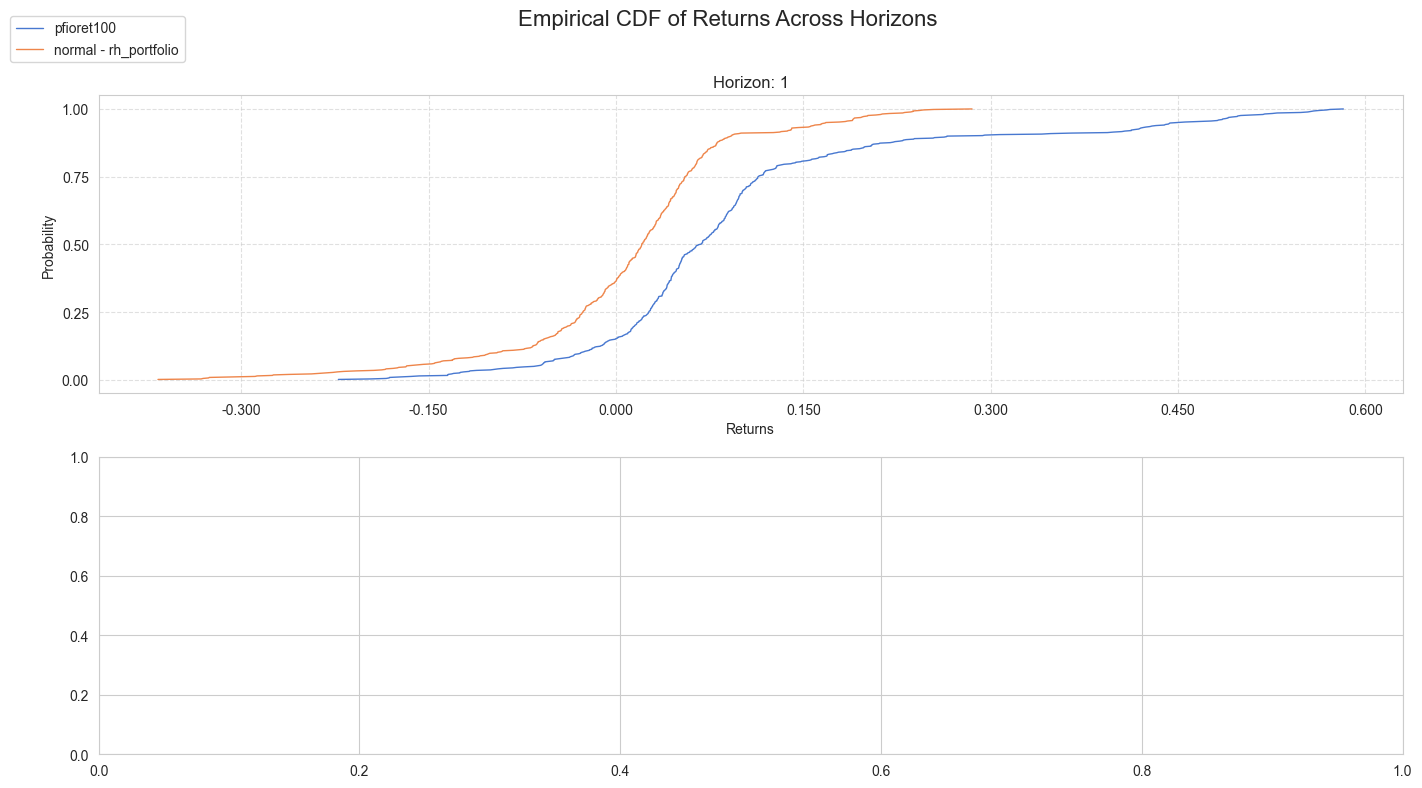

In [18]:
from src.visuals.plotter import Plotter, ReturnSeries

plotter = Plotter([ReturnSeries(label="normal", df=df_plot, horizons=[1]),
                   ReturnSeries(label="div", df=r_div, horizons=[1])])
plotter.plot_returns_timeseries()
plotter.plot_returns_cdfs()